# Training a deep neural network

In this task we consider the following problem as our optimization problem:

\begin{equation*}
\underset{W_1,W_2,w_3}{\text{minimize}} \; \frac{1}{N} \sum_{i\in [N]} ||w_3s(W_2s(W_1x_i)-y_i)||_2^2
\end{equation*}

where s is sigmoid function with the formula s = 1/(1+exp(-x)). We also can add the our choice of regulizer. As we can see from the above formula, we can implement our potimization problem with a neural network with two hidden layers and one output layer. All the activation functions of our neural network will be sigmoid function. Since the size of $W_3$ and $W_2$ and $W_1$ is not specified we can set it by our choice. We can also add $L_2$ normalizer to our neural network. 

In the first part of our code we will implement our neural network with different otimizers (GD, SGD, SVRG, SAG). We will use Keras library and python. 

## 1. Data preparation

The data sets are same as CA1 and CA2. Before starting to work with the data sets we will discuss that how we use the data sets. As we do not have any condition on the way we use these data sets, we can choose only some prefered feture set of the data sets. We prepare our data sets following the bellow steps.

- The firs two feilds of "Individual household electric power consumption" data set are timestamp and date. We can simply eliminate these fields since the goal of this assignment is not finding a very accurate model for this data set (The goal is comparing different solvers using neural network for same data sets). The other professional way of using these columns is to convert these columns to integer values of time and using them.

- Both data sets have missing values. There are different ways of handling missing values. In this assignment similar to CA2 we just replace these missing values with zeros. 

- In this assignment since we use neural network with sigmoid as our activation function, we will use normalization preprocessing of data to prevent our network from satiate (sigmoid function is usually sensitive to range of our input space and it will saturate very fast with respect to range of input values and in these case our otimozer will become very slow, so we can set the mean value of our input to 0 and standard deviation to 1). For preprocessing, Scikit library has different functions.  The two functions that we can use is preprocessing.scale and preprocessing.normalize which do same action on data with different ways (normalizing along one axis or whole axis of data). We will use preprocessing.scale which normalize the input space over all axis of input data.

In [102]:
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import random

In [2]:
data = pd.read_csv("household_power_consumption.txt",";")

print("The size of data set is:",data.shape)
print("The first three rows of data set:\n",data.head(2))
print("The last three rows of data set:\n",data.tail(2))

X_ = pd.DataFrame(data.iloc[:,2:6], columns=["Global_active_power","Global_reactive_power","Voltage","Global_intensity"])
Y_ = pd.DataFrame(data.iloc[:,7], columns=["Sub_metering_2"])

X_ = X_.replace({'?':0})
Y_ = Y_.replace({'?':0})

/Users/shahab/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The size of data set is: (2075259, 9)
The first three rows of data set:
          Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
The last three rows of data set:
                Date      Time Global_active_power Global_reactive_power  \
2075257  26/11/2010  21:01:00               0.934                     0   
2075258  26/11/2010  21:02:00               0.932                     0   

        Voltage Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
2075257   239.7              3.8              0              0             0.0  
2075258  239.55              3.8              0              0       

### 1.1 train and test sets

Befor starting the training we need to split our data to train and test. In traditional learning algorithms, people usually use 70%/30% train/test or 60%/20%/20% train/dev/test set. Nowadays, because of having large data sets, people usually use 98%/1%/1% train/dev/test set. In this assignment we used the traditional way of spliting data into train and test with the ratio of 70%/30% of train/test.

In [3]:
X_features = X_.columns
Y_features = Y_.columns
number_of_samples = 3600
XY = pd.concat([X_[X_features], Y_[Y_features]], axis=1).iloc[0:number_of_samples,:]

# Split XY into training set and test set of equal size
train, test = train_test_split(XY, test_size = 0.30)
# Sort the train and test sets after index (which became unsorted through sampling)
train = train.sort_index(axis=0)
test = test.sort_index(axis=0)

# Extract X,Y components from test and train sets
X_train = train[X_features].astype(float); X_test = test[X_features].astype(float)
Y_train = train[Y_features].astype(float); Y_test = test[Y_features].astype(float)

print("Size of train set (X): ",X_train.shape)
print("Size of train set (Y): ",Y_train.shape)
print("Size of test set (X): ",X_test.shape)
print("Size of test set (Y): ",Y_test.shape)

Size of train set (X):  (2520, 4)
Size of train set (Y):  (2520, 1)
Size of test set (X):  (1080, 4)
Size of test set (Y):  (1080, 1)


## 2. Defining metrics for comparing the models and methods

In this part we will introduce our metric that it gives us the possiblity of comparing the methods and the accuracy of our models when we predict our target variable for test set. We will use Normalized Mean Absolute Error.

We use following formula to compute this error:

\begin{equation*}
\frac{1}{\bar{y}}(\frac{1}{m}\sum\limits_{i=1}^m|y_i-\hat{y_i}|)
\end{equation*}

In [4]:
def nmae(y,yhat):
    y = np.array(y).reshape(y.shape[0],1)
    yhat = np.array(yhat).reshape(yhat.shape[0],1)
    result = np.sum(np.abs(y-yhat))/(y.shape[0]*np.mean(y))
    return result

In [5]:
y = np.array([1,2,3,4])
yhat = np.array([2,1,3,4])
print(nmae(y,yhat))

0.2


## 2. Defining a Naive and baseline models

In this section we will specify two other models which will be our baseline and naive estimators (just to know and understand and have feeling about the prediction and modeling environment). Our Naive estimator can be the mean value of our target variable. We can use random forest model as our base line model. We can compare the results of our neural network with the results of these two models to assess the accuracy of our model (although the goal of this assignment is not to find a good estimator, we can just be sure that we are not wasting time with wrong model). However, when we are using neural networks we can not necceraly be shure that in our first attempt we will have a good model as our baseline or even our naive method. We usually need to tune different hyper-parameters in our neural network. Such as the architecture which is simply the size of our matrices in this assignment.

In [6]:
def naive(y):
    return np.mean(y)

In [7]:
naive_estimator = naive(Y_train)
print(naive_estimator)

Sub_metering_2    2.099206
dtype: float64


In [8]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=120, n_jobs=-1)
regressor.fit(X_train, Y_train)
test_pred = regressor.predict(X_test)
train_pred = regressor.predict(X_train)

/Users/shahab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [9]:
test_nmae = nmae(Y_test,test_pred)
train_nmae = nmae(Y_train,train_pred)
naive_values = np.full((Y_train.shape[0],1),naive_estimator)
naive_nmae = nmae(Y_train,naive_values)
print("The test NMAE is %.2f" %test_nmae)
print("The train NMAE is %.2f" %train_nmae)
print("The naive NMAE is %.2f" %naive_nmae)

The test NMAE is 0.93
The train NMAE is 0.35
The naive NMAE is 1.53


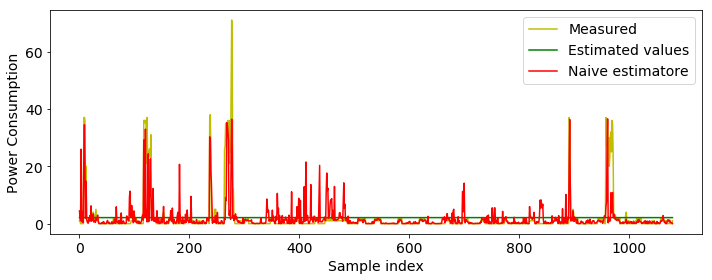

In [10]:
import matplotlib.pyplot as plt
N_size = min(X_test.shape[0],number_of_samples)
baseline_value = Y_train.mean()
baseline_array = np.zeros(N_size)
for i in range(0,N_size):
    baseline_array[i] = baseline_value
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
line = plt.plot(np.linspace(0, N_size-1, N_size),Y_test[0:N_size], color='y')
baseline = plt.plot(np.linspace(0, N_size-1, N_size),baseline_array[0:N_size], color='g')
predict_line = plt.plot(np.linspace(0, N_size-1, N_size),test_pred[0:N_size], color='red')

font_size = 14
plt.xlabel('Sample index', fontsize=font_size)
plt.ylabel('Power Consumption', fontsize=font_size)
plt.legend(('Measured', 'Estimated values','Naive estimatore'), loc = 'upper right', shadow=False, fancybox=True, fontsize=font_size)
plt.tick_params(axis='both', which='major', labelsize=font_size)
plt.tick_params(axis='both', which='minor', labelsize=font_size)
plt.rcParams['savefig.dpi'] = 200
plt.tight_layout()
plt.show()

## 3. Neural Network with different optimizers

Now we are ready to implement our model with different optimizers. In the first part we will just do the first try to achive the acceptable results incomparision to our baseline and naive model. In the second part we will discuss about the different parameters.


### 3.1 In the first step we will start with a very simple neural network with GD optimizer.

In [11]:
# feature standarization: mean=0, variance=1
from sklearn import preprocessing
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

In [12]:
print(X_train.shape)

(2520, 4)


In [210]:
# GRADED FUNCTION: initialize_parameters_deep

epsilon = 1e-9
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * epsilon
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [211]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[  1.78862847e-09   4.36509851e-10   9.64974681e-11  -1.86349270e-09
   -2.77388203e-10]
 [ -3.54758979e-10  -8.27414815e-11  -6.27000677e-10  -4.38181690e-11
   -4.77218030e-10]
 [ -1.31386475e-09   8.84622380e-10   8.81318042e-10   1.70957306e-09
    5.00336422e-11]
 [ -4.04677415e-10  -5.45359948e-10  -1.54647732e-09   9.82367434e-10
   -1.10106763e-09]]
b1 = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
W2 = [[ -1.18504653e-09  -2.05649899e-10   1.48614836e-09   2.36716267e-10]
 [ -1.02378514e-09  -7.12993200e-10   6.25244966e-10  -1.60513363e-10]
 [ -7.68836350e-10  -2.30030722e-10   7.45056266e-10   1.97611078e-09]]
b2 = [[ 0.]
 [ 0.]
 [ 0.]]


In [212]:
# GRADED FUNCTION: linear_forward

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A)+b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [213]:
def relu(x):
    activation_cache = {"Z": x}
    A = x * (x > 0)
    return A,activation_cache

def drelu(x):
    return 1. * (x > 0)

In [214]:
def lrelu(x):
    activation_cache = {"Z": x}
    A = x
    A[x < 0] = 0.01 * A[x < 0]
    return A

def dlrelu(x):
    dx = np.ones_like(x,np.float64)
    dx[x < 0] = 0.01
    return dx

In [215]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1/(1+np.exp((-1)*z))
    
    activation_cache = {"Z": z}
    
    return s,activation_cache
def dsigmoid(z):

    s = z*(1-z)
    
    return s

In [216]:
# GRADED FUNCTION: sigmoid

def tanh(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = (np.exp(z)+np.exp((-1)*z))/(np.exp(z)+np.exp((-1)*z))
    
    activation_cache = {"Z": z}
    
    return s,activation_cache
def dtanh(z):

    s = 1-(z*z)
    
    return s

In [217]:
def linear(z):
    s=z
    activation_cache = {"Z":z}
    return s,activation_cache

def dlinear(z):
    return 1

In [218]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    elif activation == "lrelu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = lrelu(Z)
    elif activation == "linear":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = linear(Z)
    elif activation == "tanh":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [219]:
# GRADED FUNCTION: L_model_forward

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "linear")
    caches.append(cache)
    
    
    #print ("AL.shape:",AL.shape," X.shape[1]:",X.shape[1])
    
    #***assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [220]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    diff = (A2-Y)**2
    cost = np.sum(diff)/m
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [221]:
AL = np.array([1,2,3]).reshape(1,3)
Y = np.array([1,2,2]).reshape(1,3)
cost = compute_cost(AL,Y)
print(cost)

0.333333333333


In [222]:
def sigmoid_backward(dA, activation_cache):
    dZ = dA*dsigmoid(activation_cache['Z'])
    return dZ

def relu_backward(dA, activation_cache):
    dZ = dA*drelu(activation_cache['Z'])
    return dZ

def lrelu_backward(dA, activation_cache):
    dZ = dA*dlrelu(activation_cache['Z'])
    return dZ

def line_backward(dA, activation_cache):
    dZ = dA*dlinear(activation_cache['Z'])
    return dZ

def tanh_backward(dA, activation_cache):
    dZ = dA*dtanh(activation_cache['Z'])
    return dZ

In [223]:
# GRADED FUNCTION: linear_backward

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ,A_prev.T)/m
    db = (np.sum(dZ,axis=1,keepdims=True)/m)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [224]:
# GRADED FUNCTION: linear_activation_backward

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    elif activation == "lrelu":
        dZ = lrelu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        #print ("dZ.shape:",dZ.shape)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    elif activation == "tanh":
        dZ = tanh_backward(dA, activation_cache)
        #print ("dZ.shape:",dZ.shape)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    return dA_prev, dW, db

In [225]:
# GRADED FUNCTION: L_model_backward

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = 2*np.sum(AL-Y)/m
    
    current_cache = caches[L-1]
    #grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "linear")

    linear_cache, activation_cache = current_cache
    A_prev, W, b = linear_cache
    
    grads["dA" + str(L)] = dAL
    grads["dW" + str(L)] = 2 * np.dot((AL-Y),A_prev.T)/m
    grads["db" + str(L)] = dAL
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
    
        current_cache = caches[l]
        #dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "lrelu")
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "sigmoid")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [226]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(1, L+1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - np.multiply(learning_rate , grads["dW"+str(l)])
        parameters["b" + str(l)] = parameters["b" + str(l)] - np.multiply(learning_rate , grads["db"+str(l)])

    return parameters

In [238]:
# GRADED FUNCTION: update_parameters

def update_parameters_SVRG(parameters, grads, grads_tilda, total_grads, learning_rate,N):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(1, L+1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - np.multiply(learning_rate , grads["dW"+str(l)]-grads_tilda["dW"+str(l)]+total_grads["dW"+str(l)]/N)
        parameters["b" + str(l)] = parameters["b" + str(l)] - np.multiply(learning_rate , grads["db"+str(l)]-grads_tilda["db"+str(l)]+total_grads["db"+str(l)]/N)

    return parameters

In [275]:
# GRADED FUNCTION: update_parameters

def update_parameters_SAG(parameters,grads, SAG_grads, random_index, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(1, L+1):
        if (l == random_index):
            parameters["W" + str(l)] = parameters["W" + str(l)] - np.multiply(learning_rate , grads["dW"+str(l)])
            parameters["b" + str(l)] = parameters["b" + str(l)] - np.multiply(learning_rate , grads["db"+str(l)])
        else:
            parameters["W" + str(l)] = parameters["W" + str(l)] - np.multiply(learning_rate , SAG_grads[l]["dW"+str(l)])
            parameters["b" + str(l)] = parameters["b" + str(l)] - np.multiply(learning_rate , SAG_grads[l]["db"+str(l)])

    return parameters

In [276]:
random_index = int(random.randint(1,X_train.shape[1]))
print(random_index)

3


In [277]:
### CONSTANTS ###
layers_dims = [4, 2, 2, 1] #  5-layer model

In [278]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, epoch_length = 50, print_cost=False, solver="GD"):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    parameters_tilda = initialize_parameters_deep(layers_dims)
    SAG_grads = [dict() for x in range(X.shape[1])]
    
    # Loop (gradient descent)
    if (solver == "GD"):
        for i in range(0, num_iterations):

            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = L_model_forward(X, parameters)

            # Compute cost.
            cost = compute_cost(AL, Y)

            # Backward propagation.
            grads = L_model_backward(AL, Y, caches)

            # Update parameters.
            parameters = update_parameters(parameters, grads, learning_rate)


    elif (solver == "SGD"):
        for i in range(0, num_iterations):
            random_index = int(random.randint(1,X.shape[1]-1))
            random_sample_X = (X[:,random_index]).reshape(X.shape[0],1)
            random_sample_Y = (Y[:,random_index]).reshape(1,1)
            
            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = L_model_forward(random_sample_X, parameters)

            # Compute cost.
            cost = compute_cost(AL, random_sample_Y)

            # Backward propagation.
            grads = L_model_backward(AL, random_sample_Y, caches)

            # Update parameters.
            parameters = update_parameters(parameters, grads, learning_rate)


        
    elif (solver == "SVRG"):
        for i in range(0, num_iterations):
            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = L_model_forward(X, parameters_tilda)

            # Compute cost.
            cost = compute_cost(AL, Y)

            # Backward propagation. Tilda gradian f
            total_grads = L_model_backward(AL, Y, caches)
            
            for j in range(0,epoch_length):
                random_index = int(random.randint(1,X.shape[1]-1))
                random_sample_X = (X[:,random_index]).reshape(X.shape[0],1)
                random_sample_Y = (Y[:,random_index]).reshape(1,1)

                # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
                AL, caches = L_model_forward(random_sample_X, parameters)

                # Compute cost.
                cost = compute_cost(AL, random_sample_Y)

                # Backward propagation.
                grads = L_model_backward(AL, random_sample_Y, caches)
                
                # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
                AL_tilda, caches_tilda = L_model_forward(random_sample_X, parameters_tilda)

                # Compute cost.
                cost_tilda = compute_cost(AL_tilda, random_sample_Y)

                # Backward propagation.
                grads_tilda = L_model_backward(AL_tilda, random_sample_Y, caches_tilda)

                # Update parameters.
                parameters = update_parameters_SVRG(parameters, grads, grads_tilda, total_grads, learning_rate,X.shape[1])
            
            parameters_tilda = parameters
            
    elif (solver == "SAG"):
        #Computing all gradients for all samples
        for i in range(X.shape[1]):
            
            sample_X = (X[:,i]).reshape(X.shape[0],1)
            sample_Y = (Y[:,i]).reshape(1,1)

            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = L_model_forward(sample_X, parameters)

            # Compute cost.
            cost = compute_cost(AL, sample_Y)

            # Backward propagation.
            grads = L_model_backward(AL, sample_Y, caches)
            SAG_grads[i] = grads
        
        
        
        for j in range(0,epoch_length):
            random_index = int(random.randint(1,X.shape[1]-1))
            random_sample_X = (X[:,random_index]).reshape(X.shape[0],1)
            random_sample_Y = (Y[:,random_index]).reshape(1,1)

            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = L_model_forward(random_sample_X, parameters)

            # Compute cost.
            cost = compute_cost(AL, random_sample_Y)
            grads = L_model_backward(AL, sample_Y, caches)
            
            # Update parameters.
            parameters = update_parameters_SAG(parameters, grads, SAG_grads, random_index, learning_rate)

    
    return parameters

In [279]:
parameters = L_layer_model(X_train.T, np.array(Y_train).T, layers_dims, solver = "SAG", learning_rate = 0.001, num_iterations = 500, print_cost = True)

In [280]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    A2, cache = L_model_forward(X,parameters)
    predictions = A2 
    
    return predictions

In [281]:
test_predicted_values = predict(parameters, X_test.T)
train_predicted_values = predict(parameters, X_train.T)
print(test_predicted_values.shape)

(1, 1080)


In [282]:
test_nmae = nmae(Y_test,test_predicted_values.T)
train_nmae = nmae(Y_train,train_predicted_values.T)
naive_values = np.full((Y_train.shape[0],1),naive_estimator)
naive_nmae = nmae(Y_train,naive_values)
print("The test NMAE is %.2f" %test_nmae)
print("The train NMAE is %.2f" %train_nmae)
print("The naive NMAE is %.2f" %naive_nmae)

The test NMAE is 1.01
The train NMAE is 1.02
The naive NMAE is 1.53


### 3.2 Comparing different models

In this part we will run our model and compare them based on training time and accuracy.

#### 3.2.1 Gradient Descent (GD)

In [287]:
import time
start = time.time()
parameters = L_layer_model(X_train.T, np.array(Y_train).T, layers_dims, solver = "GD", learning_rate = 0.001, num_iterations = 500, print_cost = True)
end = time.time()

train_time = end - start 
print("Training time is %.2f" %train_time)

Training time is 0.13


In [288]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    A2, cache = L_model_forward(X,parameters)
    predictions = A2 

    
    return predictions

In [289]:
test_predicted_values = predict(parameters, X_test.T)
train_predicted_values = predict(parameters, X_train.T)
print(test_predicted_values.shape)

(1, 1080)


In [290]:
test_nmae = nmae(Y_test,test_predicted_values.T)
train_nmae = nmae(Y_train,train_predicted_values.T)
naive_values = np.full((Y_train.shape[0],1),naive_estimator)
naive_nmae = nmae(Y_train,naive_values)
print("The test NMAE is %.2f" %test_nmae)
print("The train NMAE is %.2f" %train_nmae)
print("The naive NMAE is %.2f" %naive_nmae)

The test NMAE is 1.24
The train NMAE is 1.26
The naive NMAE is 1.53


#### 3.2.2 Stochastic Gradient Descent (SGD)

In [291]:
import time
start = time.time()
parameters = L_layer_model(X_train.T, np.array(Y_train).T, layers_dims, solver = "SGD", learning_rate = 0.001, num_iterations = 500, print_cost = True)
end = time.time()

train_time = end - start 
print("Training time is %.2f" %train_time)

Training time is 0.06


In [292]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    A2, cache = L_model_forward(X,parameters)
    predictions = A2 
    
    return predictions

In [293]:
test_predicted_values = predict(parameters, X_test.T)
train_predicted_values = predict(parameters, X_train.T)
print(test_predicted_values.shape)

(1, 1080)


In [294]:
test_nmae = nmae(Y_test,test_predicted_values.T)
train_nmae = nmae(Y_train,train_predicted_values.T)
naive_values = np.full((Y_train.shape[0],1),naive_estimator)
naive_nmae = nmae(Y_train,naive_values)
print("The test NMAE is %.2f" %test_nmae)
print("The train NMAE is %.2f" %train_nmae)
print("The naive NMAE is %.2f" %naive_nmae)

The test NMAE is 1.24
The train NMAE is 1.26
The naive NMAE is 1.53


#### 3.2.3 Stochastic variance reduced gradient (SVRG)

In [295]:
import time
start = time.time()
parameters = L_layer_model(X_train.T, np.array(Y_train).T, layers_dims, solver = "SVRG", learning_rate = 0.001, num_iterations = 500, print_cost = True)
end = time.time()

train_time = end - start 
print("Training time is %.2f" %train_time)

Training time is 5.67


In [296]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    A2, cache = L_model_forward(X,parameters)
    predictions = A2 
    
    return predictions

In [297]:
test_predicted_values = predict(parameters, X_test.T)
train_predicted_values = predict(parameters, X_train.T)
print(test_predicted_values.shape)

(1, 1080)


In [298]:
test_nmae = nmae(Y_test,test_predicted_values.T)
train_nmae = nmae(Y_train,train_predicted_values.T)
naive_values = np.full((Y_train.shape[0],1),naive_estimator)
naive_nmae = nmae(Y_train,naive_values)
print("The test NMAE is %.2f" %test_nmae)
print("The train NMAE is %.2f" %train_nmae)
print("The naive NMAE is %.2f" %naive_nmae)

The test NMAE is 1.01
The train NMAE is 1.01
The naive NMAE is 1.53


#### 3.2.4 Stochastic average gradient (SAG)

In [300]:
import time
start = time.time()
parameters = L_layer_model(X_train.T, np.array(Y_train).T, layers_dims, solver = "SAG", learning_rate = 0.001, num_iterations = 500, print_cost = True)
end = time.time()

train_time = end - start 
print("Training time is %.2f" %train_time)

Training time is 0.25


In [301]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    A2, cache = L_model_forward(X,parameters)
    predictions = A2 
    
    return predictions

In [302]:
test_predicted_values = predict(parameters, X_test.T)
train_predicted_values = predict(parameters, X_train.T)
print(test_predicted_values.shape)

(1, 1080)


In [303]:
test_nmae = nmae(Y_test,test_predicted_values.T)
train_nmae = nmae(Y_train,train_predicted_values.T)
naive_values = np.full((Y_train.shape[0],1),naive_estimator)
naive_nmae = nmae(Y_train,naive_values)
print("The test NMAE is %.2f" %test_nmae)
print("The train NMAE is %.2f" %train_nmae)
print("The naive NMAE is %.2f" %naive_nmae)

The test NMAE is 1.01
The train NMAE is 1.02
The naive NMAE is 1.53


# Discussion

If we compare methods and the results, we can see that the most accurate algorithm with specified architecture for neural network, fixed numbr of epochs and learning rate, is SVRG the next accurate is SAG and GD and last one is SGD. If compare training time we can see that the fastest algorithm is SGD the second one is GD, and the next one is SAG and last one is SVRG.

We have to notice that all these results are primary results and we need to tune every thing to get good results. As we know there are different parameters here that we can tunel like the architecture, optimizer paramters (learning rate, epochs, epoch length for SVRG and so on). To tune the parameters very similar to task two we can specify the space of hyper-paramters and select points in this space, then define models with the hyper-parameters and train the models. We select the models with lowest error or highest accuracy of our metric (here we chose NMAE). And we can continue to select best paramters.  